### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

### Set Seed

In [2]:
SEED = 42

### Load Full Data

In [3]:
DATA_FOLDER_PATH = os.path.normpath(os.path.join("..", "data"))
medquad = pd.read_csv(os.path.join(DATA_FOLDER_PATH, "raw", "medquad.csv"))

In [4]:
print(f"Shape of full dataset: {medquad.shape}")

Shape of full dataset: (16412, 4)


### Using Subset of Data

We shall scope our project in the following ways:

- For our use case, we do not want to train our model to produce long-winded answers. Hence we will only consider rows corresponding to answers that are shorter than a maximum length.
- Ignore rows that have missing values in "question" and "answer".
- Only consider common focus areas. In other words, we will remove rows corresponding to focus areas which do not meet a minimum frequency count.

In [5]:
def get_focus_area_counts(medquad_df):
    return medquad_df \
        .groupby("focus_area") \
        .count()[["question"]] \
        .reset_index() \
        .sort_values(by="question", ascending=False)

def find_common_focus_areas(medquad_df, min_question_count):
    counts_per_focus_area = get_focus_area_counts(medquad_df=medquad_df)
    common_focus_areas_with_counts = counts_per_focus_area[counts_per_focus_area["question"] >= min_question_count]
    
    return set(common_focus_areas_with_counts["focus_area"])

In [6]:
def remove_rows(medquad_df, min_question_count, max_answer_length):
    # Remove rows with missing questions / answer
    medquad_df = medquad_df.dropna(subset=["question", "answer"])

    # Impute missing focus area with "Others"
    medquad_df = medquad_df.fillna(
        {"focus_area": "Others"}
    )

    # Remove rows with abnormally long answers (below a certain cutoff)
    medquad_df["answer_length"] = medquad_df["answer"].apply(lambda ans: len(ans.split()))
    medquad_df = medquad_df[medquad_df["answer_length"] <= max_answer_length]
    
    # Drop answer length columns
    medquad_df = medquad_df.drop(["answer_length"], axis=1)

    # Only consider focus areas with a minimum frequency
    medquad_df = medquad_df[
        medquad_df["focus_area"].isin(
            find_common_focus_areas(medquad_df, min_question_count)
        )
    ]

    return medquad_df

In [7]:
MIN_QUESTION_COUNT = 2
MAX_ANSWER_LENGTH = 1500   # In terms of approximate number of words (separated by spaces)

medquad_raw_df = remove_rows(
    medquad_df=medquad,
    min_question_count=MIN_QUESTION_COUNT,
    max_answer_length=MAX_ANSWER_LENGTH
)

print(f"Shape after removing rows: {medquad_raw_df.shape}")

Shape after removing rows: (13946, 4)


### Train-Valid-Test Split

We use stratified split to preserve the composition of focus areas, as much as possible.

In [8]:
# Split data
VAL_TEST_SIZE = 0.2

medquad_df_train, medquad_df_val_test = train_test_split(
    medquad_raw_df,
    test_size=VAL_TEST_SIZE,
    random_state=SEED,
    stratify=medquad_raw_df["focus_area"]
)

# first, get those that cannot be stratified further
counts = medquad_df_val_test['focus_area'].value_counts()
cannot_stratify_classes = counts[counts < 2].index
cannot_stratify = medquad_df_val_test[medquad_df_val_test['focus_area'].isin(cannot_stratify_classes)]
# get those that can stratify
can_stratify = medquad_df_val_test[~medquad_df_val_test['focus_area'].isin(cannot_stratify_classes)]

medquad_df_val_can, medquad_df_test_can = train_test_split(
    can_stratify,
    test_size=0.5, # split half between test and validation
    random_state=SEED,
    stratify=can_stratify['focus_area']
)

# randomly place those that cannot be stratified into either train or test
medquad_df_val_cannot, medquad_df_test_cannot = train_test_split(
    can_stratify,
    test_size=0.5, # split half between test and validation
    random_state=SEED
)

# concat them together
medquad_df_val = pd.concat([medquad_df_val_can, medquad_df_val_cannot]).sample(frac=1, random_state=SEED)
medquad_df_test = pd.concat([medquad_df_test_can, medquad_df_test_cannot]).sample(frac=1, random_state=SEED)

In [9]:
print(f"Final shape after processing train: {medquad_df_train.shape}")
print(f"Final shape after processing validation: {medquad_df_val.shape}")
print(f"Final shape after processing test: {medquad_df_test.shape}")

Final shape after processing train: (11156, 4)
Final shape after processing validation: (802, 4)
Final shape after processing test: (804, 4)


In [10]:
medquad_df_train.head(5)

,question,answer,source,focus_area
8855,What are the treatments for Refsum Disease ?,The primary treatment for ARD is to restrict o...,NINDS,Refsum Disease
15702,What are the symptoms of What I need to know a...,Common symptoms of lactose intolerance include...,NIDDK,What I need to know about Lactose Intolerance
16011,What are the treatments for Prostate Enlargeme...,The complications of benign prostatic hyperpla...,NIDDK,Prostate Enlargement: Benign Prostatic Hyperpl...
4581,What are the symptoms of Naegeli syndrome ?,What are the signs and symptoms of Naegeli syn...,GARD,Naegeli syndrome
6678,What is (are) HTLV-1 associated myelopathy/tro...,HTLV-1 associated myelopathy/tropical spastic ...,GARD,HTLV-1 associated myelopathy/tropical spastic ...


In [11]:
medquad_df_val.head(5)

,question,answer,source,focus_area
326,What causes Age-related Macular Degeneration ?,Drusen alone do not usually cause vision loss....,NIHSeniorHealth,Age-related Macular Degeneration
754,What are the treatments for Heart Failure ?,"There is no cure for heart failure, but it can...",NIHSeniorHealth,Heart Failure
8464,What causes Stroke ?,Ischemic Stroke and Transient Ischemic Attack\...,NHLBI,Stroke
6851,What are the symptoms of Troyer syndrome ?,What are the signs and symptoms of Troyer synd...,GARD,Troyer syndrome
1077,what research (or clinical trials) is being do...,New types of treatment are being tested in cli...,CancerGov,Pancreatic Cancer


In [12]:
medquad_df_test.head(5)

,question,answer,source,focus_area
8439,What are the symptoms of Arrhythmia ?,Many arrhythmias cause no signs or symptoms. W...,NHLBI,Arrhythmia
718,What causes Dry Eye ?,"Many factors can lead to dry eye, including ag...",NIHSeniorHealth,Dry Eye
15611,What causes Kidney Stones in Adults ?,Kidney stones can form when substances in the ...,NIDDK,Kidney Stones in Adults
3880,What is (are) Schizencephaly ?,Schizencephaly is a rare congenital (present f...,GARD,Schizencephaly
104,Who is at risk for Diabetes? ?,"Diabetes is a serious, life-long disease. It c...",NIHSeniorHealth,Diabetes


### Checking Processed Data

#### Check for NaNs

In [13]:
medquad_df_train.isna().sum()

question      0
answer        0
source        0
focus_area    0
dtype: int64

In [14]:
medquad_df_val.isna().sum()

question      0
answer        0
source        0
focus_area    0
dtype: int64

In [15]:
medquad_df_test.isna().sum()

question      0
answer        0
source        0
focus_area    0
dtype: int64

#### Check Focus Areas

Since some focus areas are rare, they may not be present in both the train and test set, even after the stratified split. At the very least, we can verify that all the focus areas in the test set are also present in the train set. This ensures that we do not evaluate the model on a focus area that it has not seen before.

In [16]:
# Check if the focus areas in the test set are also in the train set
focus_area_train = set(medquad_df_train["focus_area"])
focus_area_val = set(medquad_df_val["focus_area"])
focus_area_test = set(medquad_df_test["focus_area"])
print(focus_area_test.issubset(focus_area_train))
print(focus_area_val.issubset(focus_area_train))

True
True


In [17]:
def plot_focus_area_counts(medquad_df_train, medquad_df_val, medquad_df_test, num_top_areas=20):
    # Select the most common classes in train
    counts_per_focus_area_train = get_focus_area_counts(medquad_df=medquad_df_train).head(num_top_areas)
    counts_per_focus_area_train["dataset"] = "train"

    # Select classes in val, corresponding to those in val
    counts_per_focus_area_val = get_focus_area_counts(medquad_df=medquad_df_val)
    counts_per_focus_area_val = counts_per_focus_area_val[
        counts_per_focus_area_val["focus_area"].isin(counts_per_focus_area_train["focus_area"])
    ]
    counts_per_focus_area_val["dataset"] = "val"

    # Select the classes in test, corresponding to those in train
    counts_per_focus_area_test = get_focus_area_counts(medquad_df=medquad_df_test)
    counts_per_focus_area_test = counts_per_focus_area_test[
        counts_per_focus_area_test["focus_area"].isin(counts_per_focus_area_train["focus_area"])
    ]
    counts_per_focus_area_test["dataset"] = "test"
    
    counts_per_focus_area = pd.concat(
        [counts_per_focus_area_train, counts_per_focus_area_val, counts_per_focus_area_test], axis=0, ignore_index=True
    )

    plt.figure(figsize=(15, 10))

    sns.barplot(
        data=counts_per_focus_area,
        x="focus_area",
        y="question",
        hue="dataset"
    )

    plt.xticks(rotation=45, ha="right")
    plt.title("Top Focus Areas by Frequency")
    plt.xlabel("Focus Area")
    plt.ylabel("Number of Samples")
    plt.show()

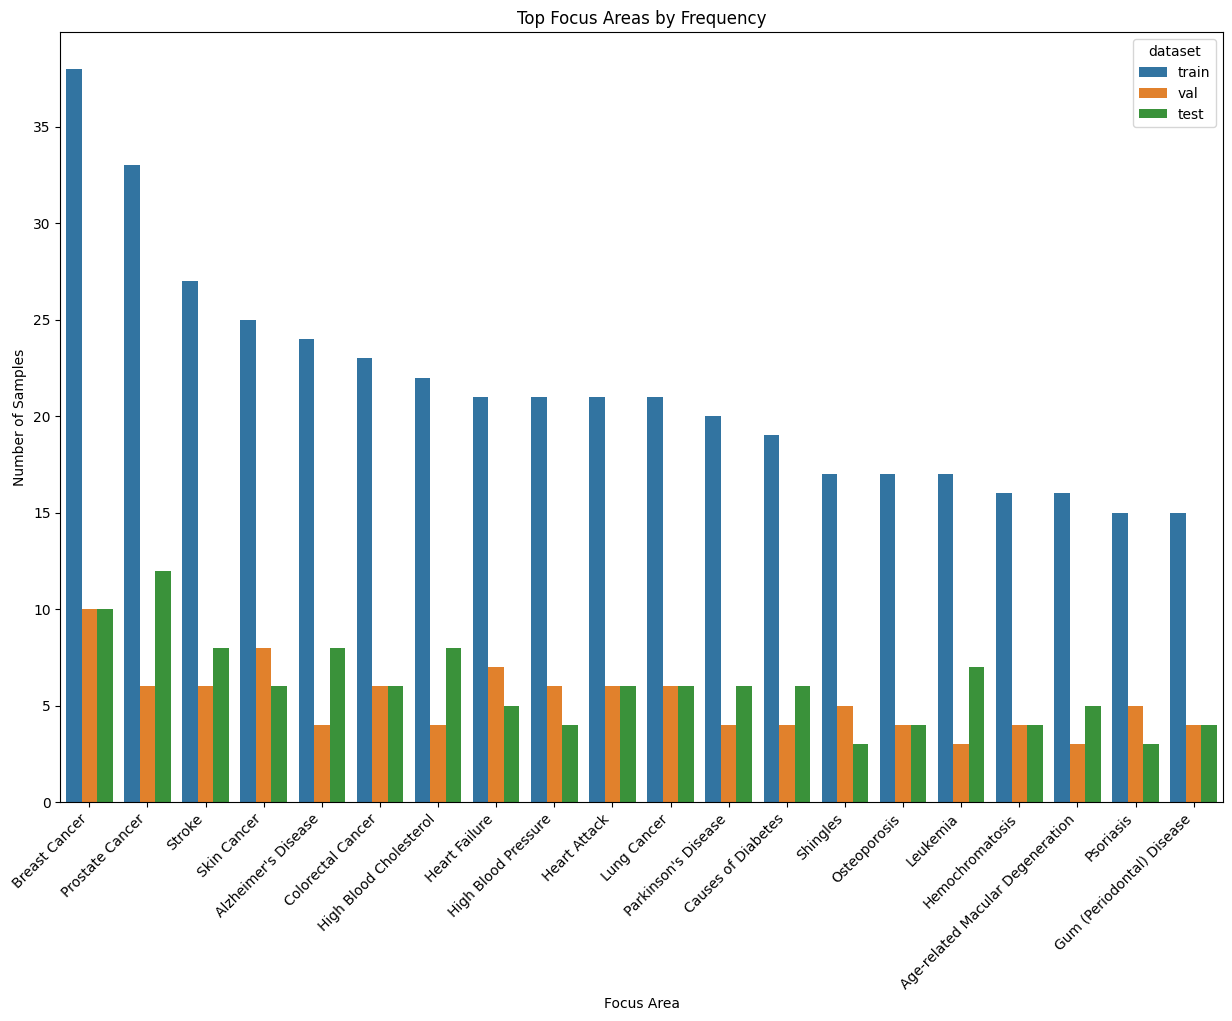

In [18]:
plot_focus_area_counts(
    medquad_df_train=medquad_df_train,
    medquad_df_val=medquad_df_val,
    medquad_df_test=medquad_df_test
)

#### Check Answer Length

In [19]:
def plot_answer_lengths(medquad_df):
    medquad_df = medquad_df.copy(deep=True)
    medquad_df["answer_length"] = medquad_df["answer"].apply(lambda x: len(x.split()))

    plt.figure(figsize=(15, 10))

    sns.histplot(
        data=medquad_df,
        x="answer_length",
        kde=True,
        bins=70
    )

    plt.title("Histogram of Answer Length")
    plt.xlabel("Answer Length")
    plt.show()

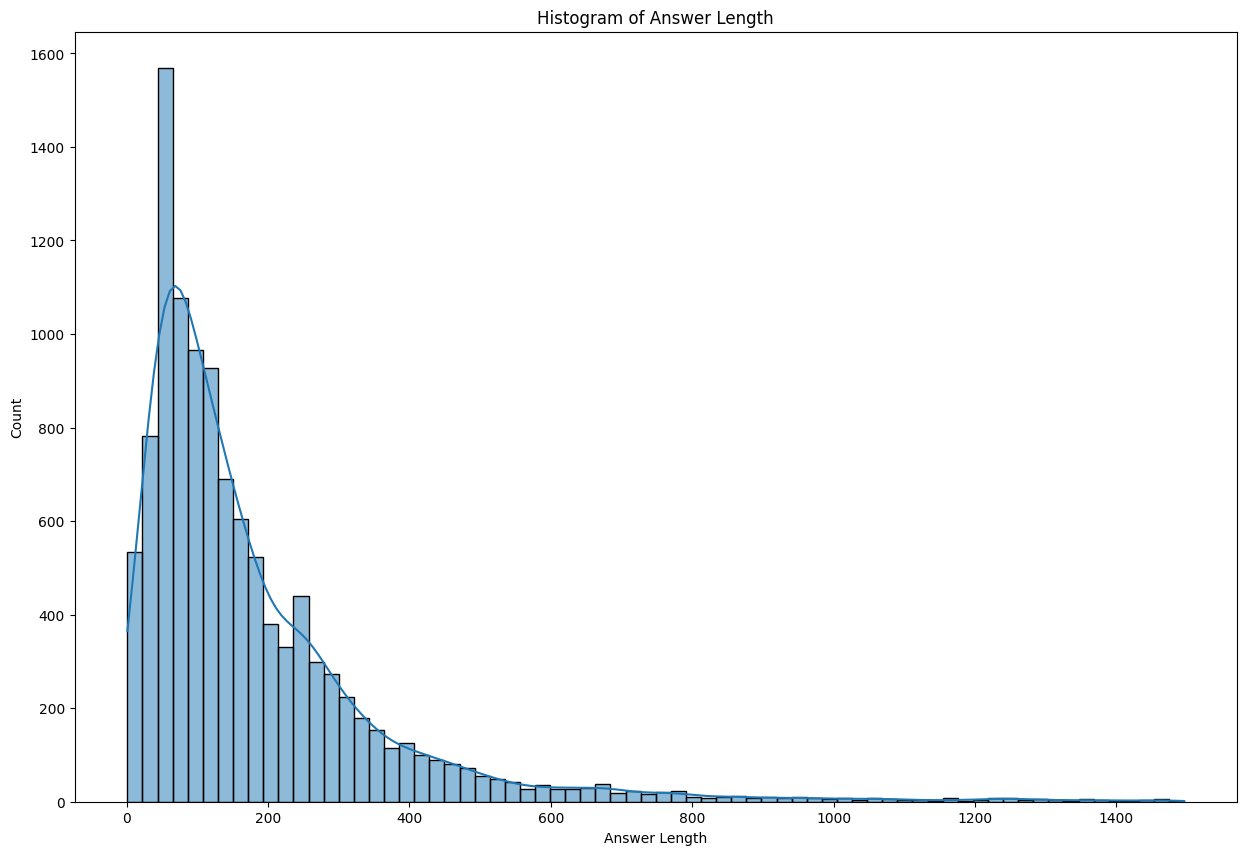

In [20]:
plot_answer_lengths(medquad_df=medquad_df_train)

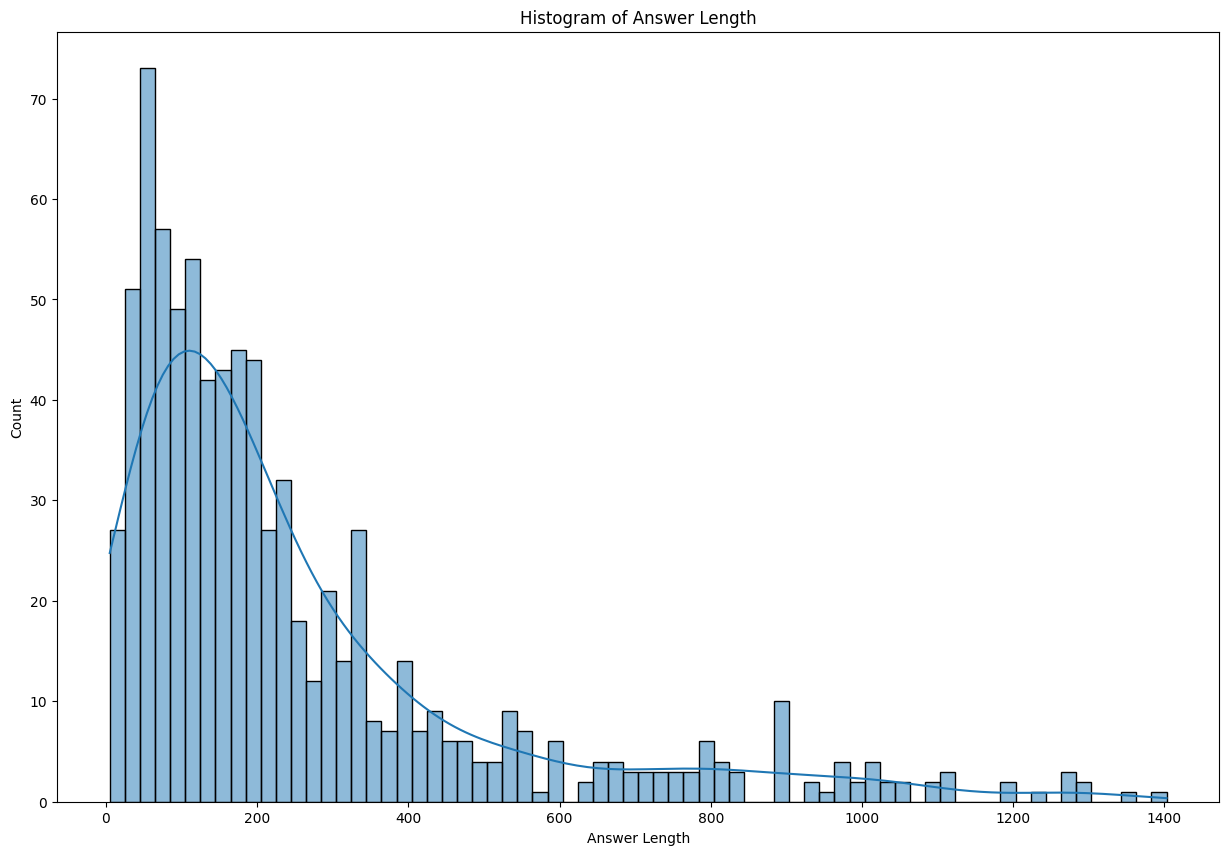

In [21]:
plot_answer_lengths(medquad_df=medquad_df_test)

### Save Processed Data

In [22]:
PROCESSED_DATA_PATH = os.path.join(DATA_FOLDER_PATH, "processed")
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
medquad_df_train.to_csv(os.path.join(PROCESSED_DATA_PATH, "train.csv"), index=False)
medquad_df_val.to_csv(os.path.join(PROCESSED_DATA_PATH, "val.csv"), index=False)
medquad_df_test.to_csv(os.path.join(PROCESSED_DATA_PATH, "test.csv"), index=False)